In [4]:
import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening,closing
from skimage.io import imread
from matplotlib import pyplot as plt
from matplotlib import patches
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import kneighbors_graph,BallTree
from hmmlearn import hmm
# from pymc3 import MCMC,flib,Model,MAP
# from ripser import Rips,ripser,plot_dgms
# from persim import PersImage
import scipy.io as sio
# import kmapper as km
# from kmapper import jupyter
from mpl_toolkits.mplot3d import Axes3D
from cell_class import single_cell,fluor_single_cell
import contour_class
import utility_tools
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
from scipy.signal import medfilt,wiener
from traj_class import single_cell_traj,fluor_single_cell_traj
# import bnpy
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from itertools import product
from sklearn.cluster import DBSCAN,KMeans,MeanShift
from sklearn.metrics import silhouette_score,davies_bouldin_score
import glob
from pykalman import KalmanFilter
from neupy import algorithms, utils
from scipy.spatial import Voronoi, voronoi_plot_2d
from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans,KShape,GlobalAlignmentKernelKMeans,silhouette_score
from tslearn.metrics import dtw,dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter,euclidean_barycenter
from sklearn.manifold import MDS,TSNE,SpectralEmbedding
from scipy import signal,stats
from statsmodels.tsa.ar_model import AR
from numpy import linalg
from scipy.interpolate import CubicSpline,interp1d
from reactive_traj_classify import find_reaction_start_end,ar1_tipping_time,cross_corr_delay,find_intermediate_part
from sklearn.utils import shuffle
from reaction_coordinates import FindPath
from skimage.filters import gaussian
from voronoi_finite_polygons_2d import voronoi_finite_polygons_2d
import scipy.stats as st
from scipy import interpolate
from matplotlib import patches
from scipy.interpolate import splprep,splev

In [5]:
main_path='single_cell_traj/'

sct_path=main_path+'4ng_traj/'

sct_list=sorted(glob.glob(sct_path+'*long_traj'))
print(len(sct_list))
result_path=main_path+'rc_result/'

with open (main_path+'morph_pc_scaler','rb') as fp:
    morph_pc_scaler=pickle.load(fp,encoding='iso-8859-1')

with open (main_path+'vim_pc_scaler','rb') as fp:
    vim_pc_scaler=pickle.load(fp,encoding='iso-8859-1')
    
with open (main_path+'label_spread_4d','rb') as fp:
    ls=pickle.load(fp,encoding='iso-8859-1')

    
t_start=0
t_end=577

217


In [6]:
nrc=24
extend_range=3

In [7]:
def consecutive_arrs(data, stepsize=3):
    return np.split(data, np.where(np.diff(data)>stepsize)[0]+1)
def find_reaction_start_end(traj_state,dwell_thres=6):
    reaction_start=traj_state.shape[0]
    reaction_end=0
    leave_E=traj_state.shape[0]
    enter_M=0

    E_arrs=consecutive_arrs(np.where(traj_state==0)[0])
    M_arrs=consecutive_arrs(np.where(traj_state==2)[0])
    I_arrs=consecutive_arrs(np.where(traj_state==1)[0])
    for m in range(len(E_arrs)):
        if E_arrs[m].shape[0]>dwell_thres:
            reaction_start=E_arrs[m][0]
            break
    l=len(I_arrs)
    for l in range(len(I_arrs)):
        if I_arrs[l].shape[0]>dwell_thres:
            leave_E=I_arrs[l][0]
            break
    
    n=len(M_arrs)
    while n>=1:
        if M_arrs[n-1].shape[0]>dwell_thres:
            reaction_end=M_arrs[n-1][-1]
            break
        n-=1
    for k in range(len(M_arrs)):
        if M_arrs[k].shape[0]>dwell_thres:
            enter_M=M_arrs[k][0]
            break
    return reaction_start,reaction_end,leave_E,enter_M

In [8]:
all_traj=[]
all_t=[]
all_traj_state=[]


all_trans_traj=[]
all_trans_t=[]

all_reaction_traj_fd=[]
all_reaction_traj=[]
all_reaction_t=[]
all_reaction_state=[]
cut_reaction_traj=[]
cut_reaction_traj_fd=[]
cut_reaction_t=[]
reactive_inds=[]
non_reactive_inds=[]
traj_ind=0

for i in range(len(sct_list)):
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp,encoding='iso-8859-1')
    if hasattr(sct,'traj_scale_cord') and hasattr(sct,'traj_vimentin_scale_haralick_pca_cord'):
        if sct.traj_scale_cord is not None:
            mask=sct.traj_vimentin_feature_values[0]!=0


            traj_t=sct.traj_seri[mask][:,0]
#             morph_traj=morph_pc_scaler.transform(sct.traj_scale_cord[mask])
#             vim_traj=vim_pc_scaler.transform(sct.traj_vimentin_scale_haralick_pca_cord[mask])
            morph_traj=(sct.traj_scale_cord[mask]-morph_pc_scaler.mean_)/np.sqrt(morph_pc_scaler.var_)
            vim_traj=(sct.traj_vimentin_scale_haralick_pca_cord[mask]-vim_pc_scaler.mean_)/np.sqrt(vim_pc_scaler.var_)

            X0=np.column_stack((morph_traj,vim_traj))
            X=np.column_stack((morph_traj[:,0],vim_traj[:,[0,2,3]]))
            X[:,2]=-X[:,2]

            

            traj_state=ls.predict(X)
            traj_proba=ls.predict_proba(X)
            
            all_traj.append(X)
            all_t.append(traj_t)
            all_traj_state.append(traj_state)#[np.where(traj_t<t_end)]


            reaction_start,reaction_end,leave_E,enter_M=find_reaction_start_end(traj_state,dwell_thres=3)
            if reaction_end>reaction_start:
                reaction_start_t=traj_t[reaction_start]
                reaction_end_t=traj_t[reaction_end]
                print('t',reaction_start_t,reaction_end_t)
            

                if reaction_start_t<=144 and reaction_end_t>144:

                    print(reaction_start,reaction_end)

                    reaction_traj=X[reaction_start:reaction_end+1,:]
                    reaction_state=traj_state[reaction_start:reaction_end+1]
                    all_reaction_traj.append(reaction_traj)
                    all_reaction_state.append(reaction_state)
                    cut_reaction_traj.append(X[reaction_start:enter_M+1,:])
                    all_reaction_t.append(traj_t[reaction_start:reaction_end+1])
                    reactive_inds.append(traj_ind)
                    all_reaction_traj_fd.append(X0[reaction_start:reaction_end+1,:])
                    
                    all_trans_traj.append(X[leave_E:enter_M+1,:])
                    all_trans_t.append(traj_t[leave_E:enter_M+1])
                else:
                    non_reactive_inds.append(traj_ind)
                    




            else:
                non_reactive_inds.append(traj_ind)
                
            traj_ind+=1

t 9.0 577.0
4 258
t 19.0 577.0
9 284
t 1.0 577.0
0 236
t 1.0 577.0
0 284
t 1.0 577.0
0 285
t 5.0 577.0
2 277
t 1.0 273.0
0 135
t 1.0 455.0
0 220
t 1.0 415.0
0 202
t 1.0 577.0
0 274
t 1.0 427.0
0 205
t 1.0 575.0
0 283
t 1.0 539.0
0 266
t 27.0 259.0
11 123
t 7.0 431.0
0 210
t 41.0 525.0
1 240
t 1.0 511.0
0 252
t 65.0 557.0
0 243
t 1.0 567.0
0 272
t 1.0 577.0
0 274
t 1.0 545.0
0 267
t 1.0 577.0
0 283
t 1.0 577.0
0 282
t 1.0 577.0
0 283
t 1.0 577.0
0 258
t 1.0 577.0
0 283
t 1.0 577.0
0 265
t 57.0 577.0
0 255
t 59.0 411.0
1 173
t 5.0 577.0
2 282
t 1.0 393.0
0 192
t 1.0 409.0
0 197
t 1.0 547.0
0 266
t 3.0 577.0
1 280
t 7.0 387.0
2 190
t 1.0 371.0
0 182
t 1.0 577.0
0 255
t 11.0 577.0
5 283
t 1.0 577.0
0 284
t 9.0 427.0
4 208
t 15.0 577.0
7 286
t 1.0 417.0
0 206
t 1.0 575.0
0 284
t 1.0 569.0
0 281
t 1.0 577.0
0 286
t 1.0 577.0
0 284
t 5.0 427.0
2 206
t 1.0 577.0
0 281
t 15.0 545.0
7 268
t 1.0 577.0
0 281
t 1.0 577.0
0 283
t 1.0 577.0
0 284
t 1.0 577.0
0 282
t 1.0 577.0
0 283
t 9.0 577.0
4 285


In [9]:
class FindPath(object):
    def __init__(self, n = 20,traj_w=10,sf=1):
        self.n = n
        self.t = np.linspace(0,1,n)
        self.error = 1e100
        self.error_log=[]
        self.data_rc=[]
        self.tangent_v=[]
        self.w=traj_w
        self.sf=sf
        
    def fit(self, p1, p2,data):
        self.p1 = np.expand_dims(p1,axis=0)
        self.p2 = np.expand_dims(p2,axis=0)
        self.data = data
        self.cluster_labels=[]

        self.spline = p1 + np.multiply((p2 - p1) , np.expand_dims(self.t,axis=1))
        plt.plot(self.spline[:,0], self.spline[:,1]) 
        plt.show()
        
        self.best_spline=self.spline.copy()
        
        update=True
        while update:
            update=self.__move()
            print(update)


        return self.best_spline,self.data_rc
    
    def __move(self):
        


        w=self.w
        traj_error_arr1,traj_sum1,pts_error_arr1,pts_sum1,density1,data_rc1=self.__error() 
        centers = self.spline.copy()
#         print(pts_sum1) 
        
        updateIndexs = np.where(density1>0)[0]
        centers[updateIndexs,:]=(np.divide(pts_sum1[updateIndexs,:],np.expand_dims(density1[updateIndexs],axis=1))+\
                                w*traj_sum1[updateIndexs,:]/len(self.data))/(1+w)



        self.spline,tangent_v=self.__discretize(centers)
        
        dot_color=np.arange(self.spline.shape[0])
        cm=plt.cm.get_cmap('jet')
        plt.figure(figsize=(7.5,5))
        plt.scatter(self.spline[:,0],self.spline[:,1],c=dot_color,cmap=cm)
        plt.xlabel('X',fontsize=16)
        plt.ylabel('Y',fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        #plt.savefig(str(self.error)+'.png',dpi=300)
        plt.show()
        traj_error_arr2,traj_sum2,pts_error_arr2,pts_sum2,density2,data_rc2=self.__error() 

#         print(w*np.sum(traj_error_arr2),np.sum(pts_error_arr2))
        error=w*np.sum(traj_error_arr2)+np.sum(pts_error_arr2)


        self.error_log.append(error)

        if error<self.error:
            self.error=error
            self.best_spline=self.spline.copy()
            self.data_rc=data_rc2
            self.tangent_v=tangent_v
            return True
        else:
            return False

        

    def __discretize(self,centers,sample_n=1,st_move=0.02):

        
        spline=centers.copy()
        centers[0,:]=self.p1#+st_move*(centers[0,:]-self.p1)#self.spline[0,:]+st_move*(centers[0,:]-self.spline[0,:])
        centers[-1,:]=self.p2#+st_move*(centers[-1,:]-self.p2)#self.spline[-1,:]+st_move*(centers[-1,:]-self.spline[-1,:])
        t = np.linspace(0,1, sample_n* self.n)

        



        center_list=[centers[:,i] for i in range(centers.shape[1])]
        tck, u = interpolate.splprep(center_list,s=self.sf,k=2)
        spline_list=splev(t,tck,ext=3)
        for k in range(len(spline_list)):
            spline[:,k]=spline_list[k][::sample_n]


        
        tangent_v=interpolate.splev(t,tck,der=1)
        
        return spline,tangent_v
        
    def __error(self):
        
        
        pts_error_arr=np.zeros(self.n)
        density = np.zeros(self.n)
        pts_sum=np.zeros_like(self.spline)
        
        traj_error_arr=np.zeros(self.n)
        traj_sum=np.zeros_like(self.spline)
        data_rc=[]
        for ind in range(len(self.data)):
            traj_t_span = self.data[ind].shape[0]
            spline_inds=[]
            spline_dist=[]
            for j in range(self.n):
                p=self.spline[j]
                
                dist=linalg.norm(self.data[ind]-p[None,:],axis=1)
#                 print(dist.shape)
                traj_error_arr[j]+=np.amin(dist)
                traj_sum[j]+=self.data[ind][np.argmin(dist),:]
                

            traj_rc=np.zeros((self.data[ind].shape[0],))
            for i in range(traj_t_span):
                p = self.data[ind][i,:]
                dist = linalg.norm(self.spline - p[None,:], axis = 1)
                pts_error_arr[np.argmin(dist)]+=np.amin(dist)
                pts_sum[np.argmin(dist)]+=self.data[ind][i,:]
                density[np.argmin(dist)]+=1
                traj_rc[i]=np.argmin(dist)
            data_rc.append(traj_rc)
            
#             traj_rc=np.zeros((self.data[ind].shape[0],))
#             rc_dtw_path=np.asarray(dtw_path(self.data[ind],self.spline)[0])
#             for i in range(traj_t_span):
#                 p = self.data[ind][i,:]
#                 p_match=rc_dtw_path[:,1][rc_dtw_path[:,0]==i]
#                 dist = linalg.norm(self.spline[p_match] - p[None,:], axis = 1)
#                 pts_error_arr[p_match[np.argmin(dist)]]+=np.amin(dist)
#                 pts_sum[p_match[np.argmin(dist)]]+=self.data[ind][i,:]
#                 density[p_match[np.argmin(dist)]]+=1
#                 traj_rc[i]=p_match[np.argmin(dist)]
#             data_rc.append(traj_rc)

        return traj_error_arr,traj_sum,pts_error_arr,pts_sum,density,data_rc

In [10]:
E_mask=np.concatenate(all_reaction_state,axis=0)==0
#E_t_mask=np.concatenate(all_reaction_t,axis=0)<48

M_mask=np.concatenate(all_reaction_state,axis=0)==2
#M_t_mask=np.concatenate(all_reaction_t,axis=0)>528
E_state_mean=np.mean(np.vstack(all_reaction_traj)[E_mask],axis=0)
M_state_mean=np.mean(np.vstack(all_reaction_traj)[M_mask],axis=0)

print(E_state_mean)
print(M_state_mean)
# [-1.893884   -1.41865059 -0.33448821 -0.42095352]
# [1.92569455 1.15847045 0.28893065 0.39622632]

[-1.87413968 -1.50508109 -0.3530134  -0.39597559]
[2.16538896 1.23075139 0.47622304 0.42784181]


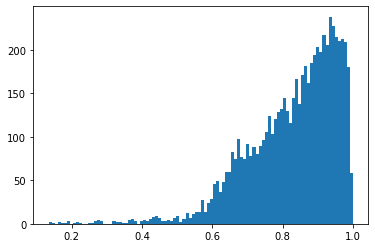

[-1.86539304 -1.4920935  -0.35473501 -0.39321202]


In [11]:
from sklearn.neighbors import KernelDensity
E_arr=np.vstack(all_reaction_traj)[E_mask]
kde = KernelDensity(kernel='gaussian', bandwidth=1.2).fit(E_arr)
E_density=np.exp(kde.score_samples(E_arr))/np.amax(np.exp(kde.score_samples(E_arr)))
plt.hist(E_density,bins=100)
plt.show()

E_state_mean=np.mean(E_arr[E_density>0.5],axis=0)
print(E_state_mean)

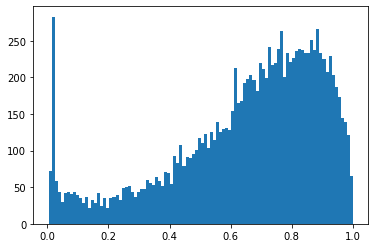

[1.45941889 1.0603215  0.50383622 0.33490984]


In [12]:
M_arr=np.vstack(all_reaction_traj)[M_mask]
kde = KernelDensity(kernel='gaussian', bandwidth=1.5).fit(M_arr)

M_density=np.exp(kde.score_samples(M_arr))/np.amax(np.exp(kde.score_samples(M_arr)))
plt.hist(M_density,bins=100)
plt.show()

M_state_mean=np.mean(M_arr[M_density>0.5],axis=0)
print(M_state_mean)

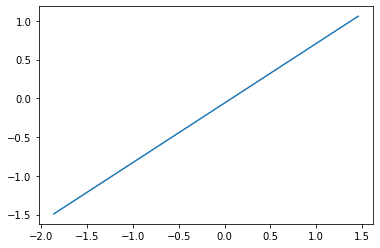

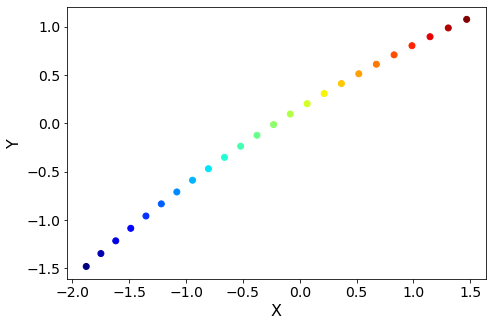

True


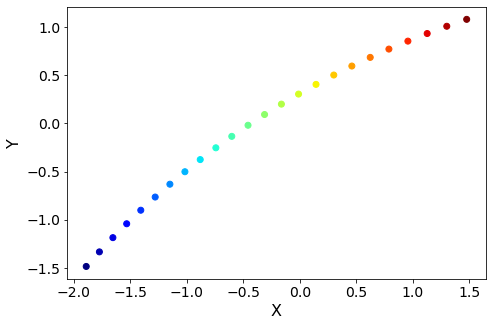

True


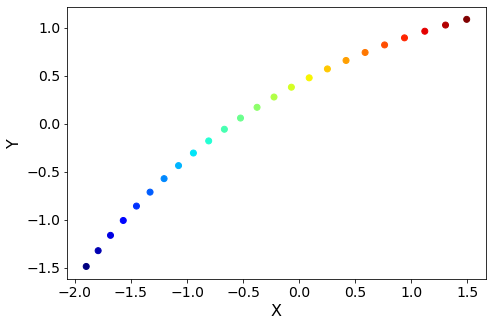

True


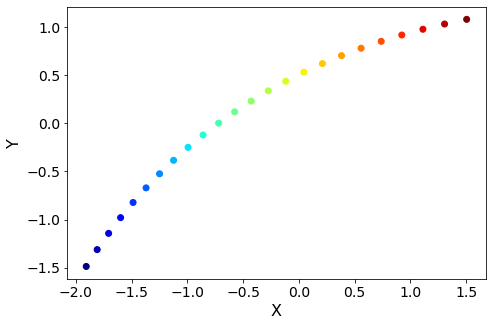

True


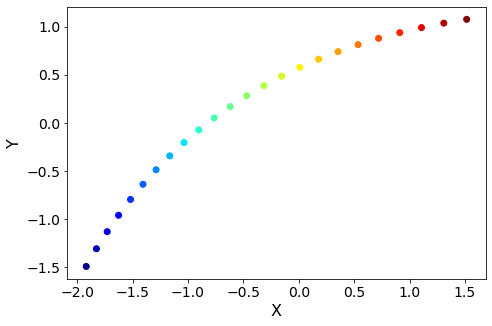

True


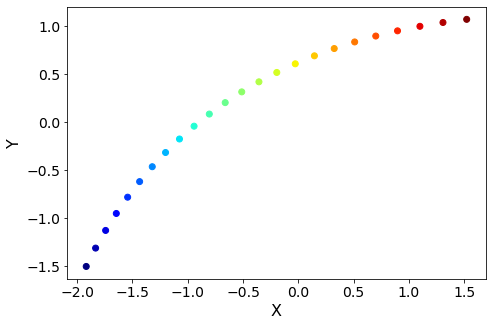

True


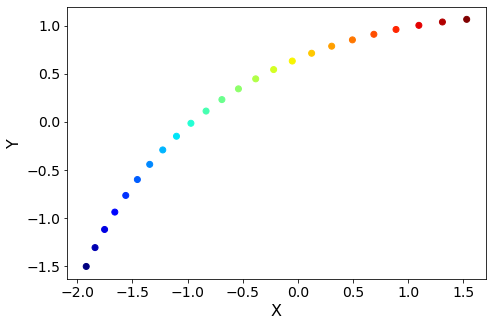

True


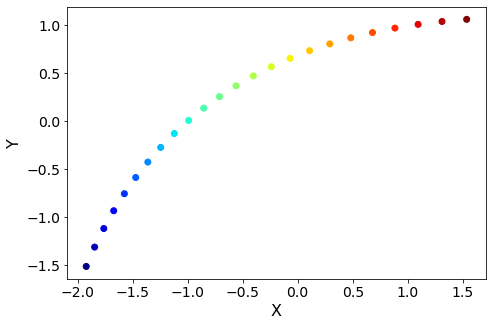

True


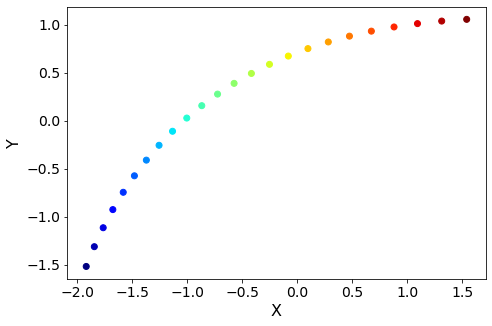

True


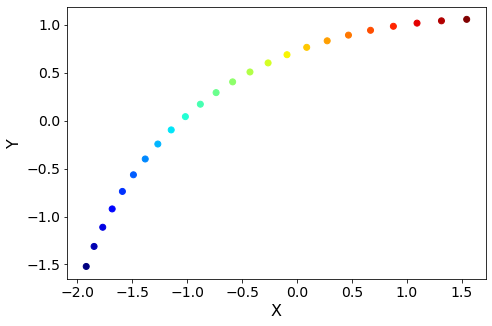

True


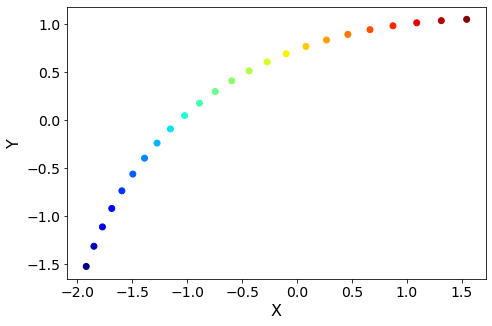

True


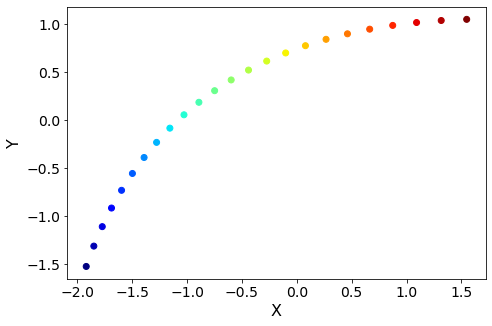

True


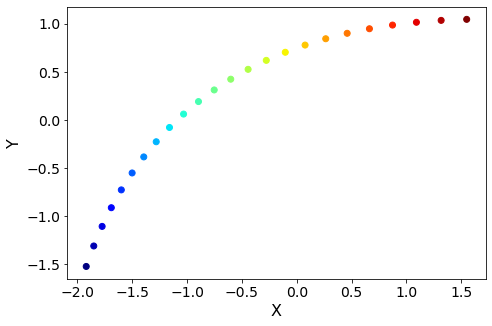

True


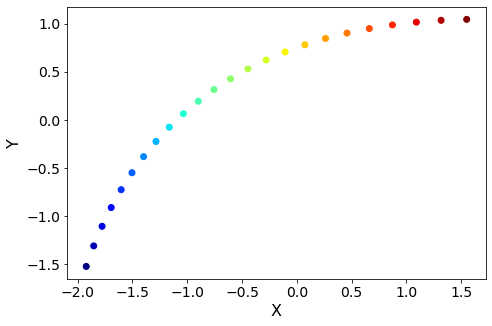

True


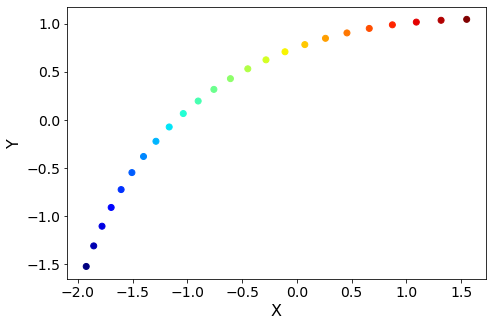

True


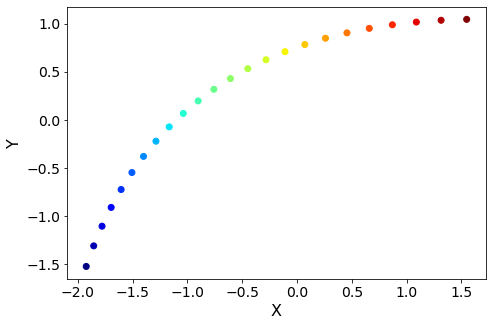

True


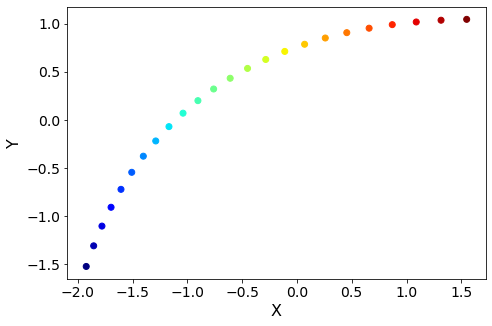

True


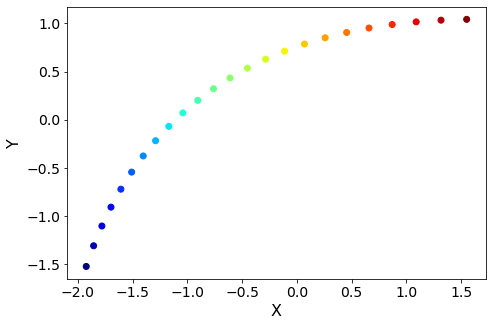

True


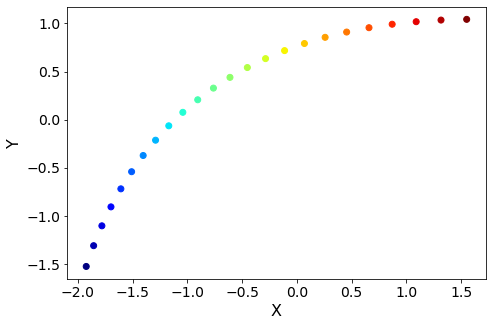

True


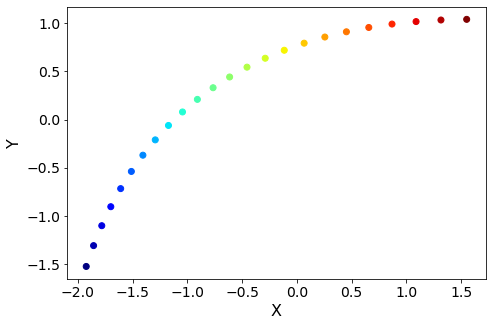

True


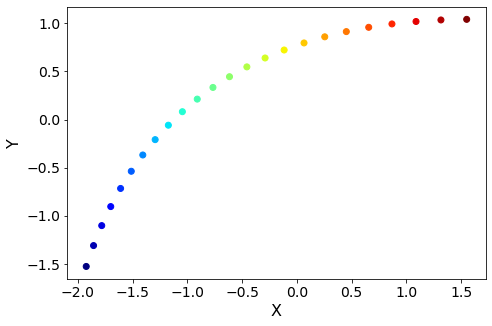

True


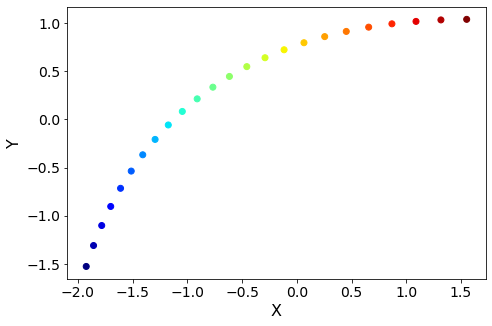

True


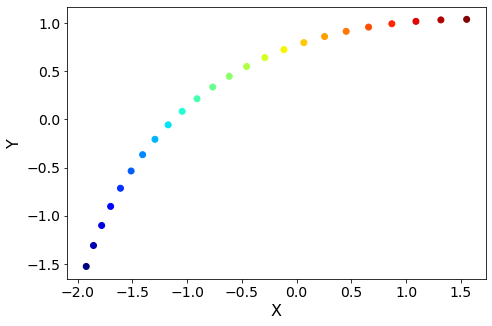

True


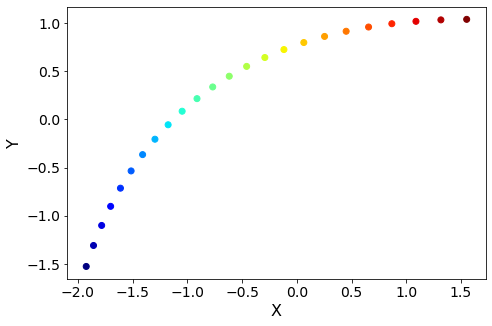

True


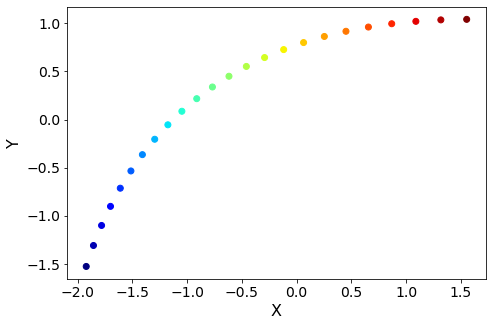

True


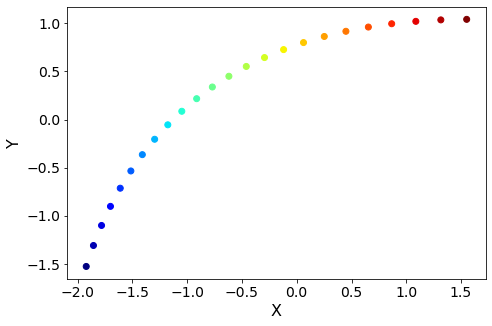

True


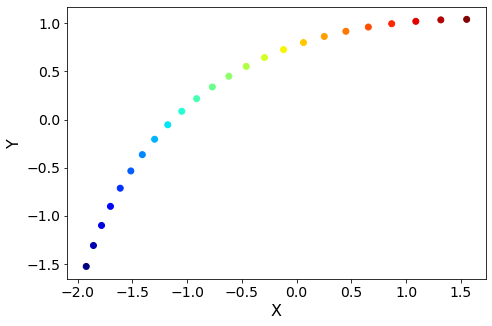

True


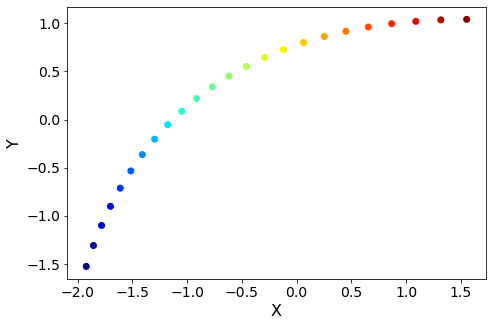

True


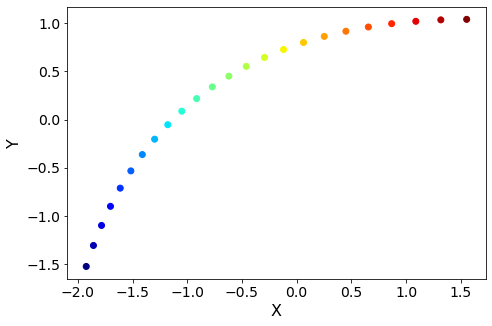

True


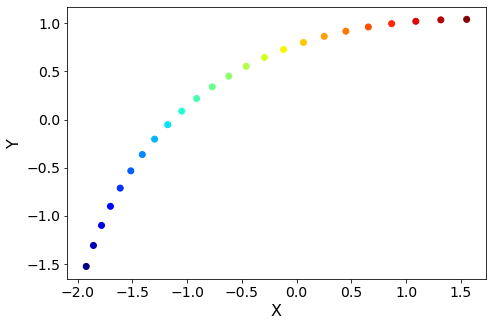

True


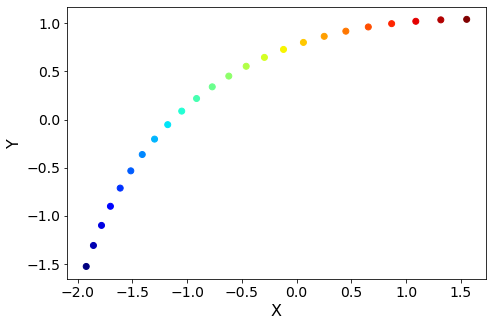

True


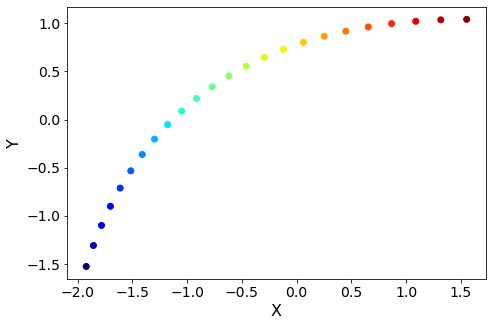

True


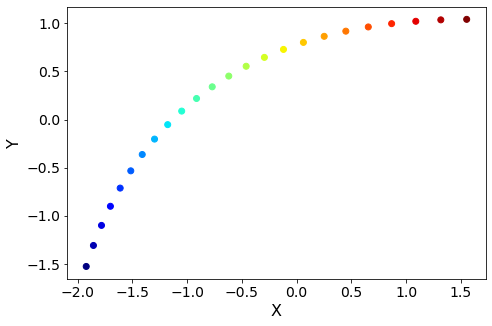

True


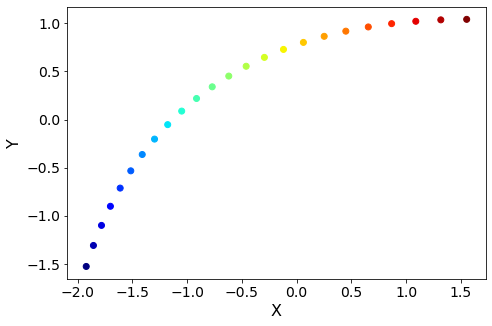

True


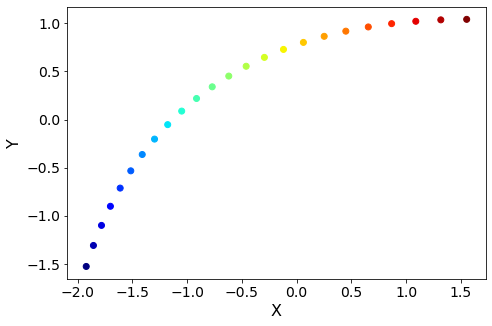

False


In [13]:
X0=all_reaction_traj
x1=E_state_mean
x2=M_state_mean


FP=FindPath(nrc,traj_w=10,sf=1)
path,data_rc=FP.fit(x1,x2,X0)
np.save(result_path+'path.npy',path)

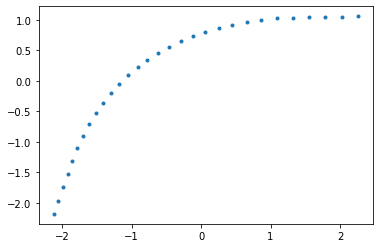

In [14]:
x = np.arange(len(path))
f = interp1d(x, path,axis=0,fill_value='extrapolate')
xnew=np.arange(-extend_range,path.shape[0]+extend_range)
extend_path = f(xnew)
plt.plot(extend_path[:,0],extend_path[:,1],'.')
plt.show()
np.save(result_path+'extend_path.npy',extend_path)